**The CIFAR-10 Dataset:**

- Contains 60,000 $32 \times 32$ color images.

- Classes (10): Airplane, Automobile, Bird, Cat, Deer, Dog, Frog, Horse, Ship, Truck.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import random

2026-02-07 05:59:39.670146: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770443979.897832      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770443979.959913      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770443980.463209      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770443980.463245      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770443980.463248      55 computation_placer.cc:177] computation placer alr

In [2]:
(x_train, y_train), (x_test, y_test) =keras.datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Data Preprocessing

In [3]:
# Normalizing Pixel valuse
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

In [4]:
x_train.shape

(50000, 32, 32, 3)

In [5]:
x_test.shape

(10000, 32, 32, 3)

In [6]:
y_train.shape

(50000, 1)

In [7]:
# Defining hyperparameter for the data
BATCH_SIZE =64
image_size =32
#converting tf.data.dataset for efficiency
train_ds = ( tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) )
val_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((x_test, y_test))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

I0000 00:00:1770444000.993122      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770444000.998936      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Visualization of CIFAR-10 Samples:

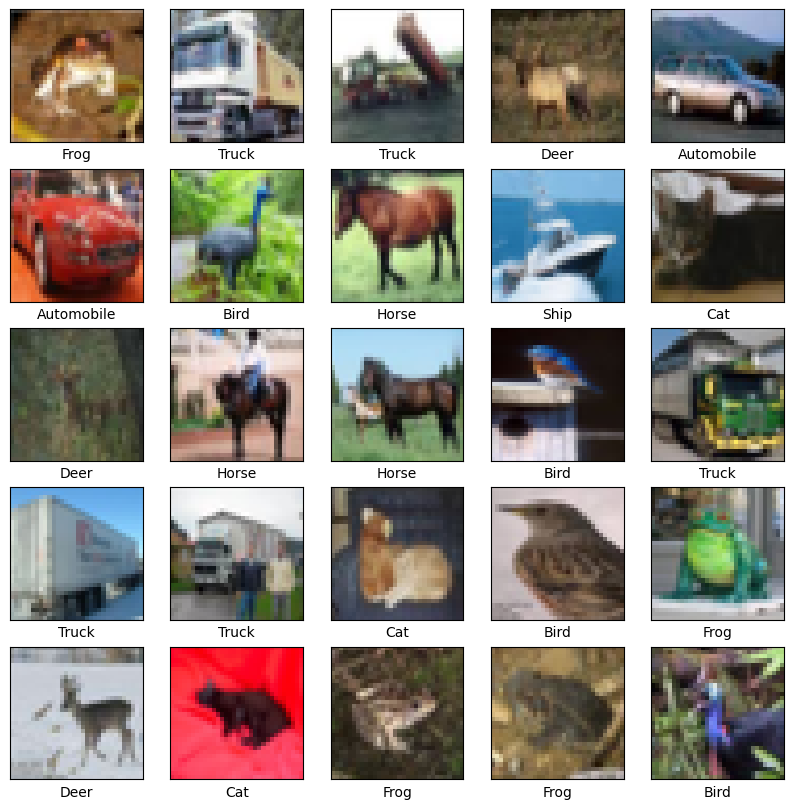

In [8]:
class_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer",
    "Dog", "Frog", "Horse", "Ship", "Truck"]
plt.figure(figsize=(10, 10))
for i in range(25):
  plt.subplot(5, 5, i + 1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(x_train[i])
  plt.xlabel(class_names[y_train[i][0]])
plt.show()

Data Augmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7450864..2.077311].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7283599..2.0333612].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8115045..2.0217125].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5280808..2.0563726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8138269..2.0570285].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5226263..2.0294905].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5977025

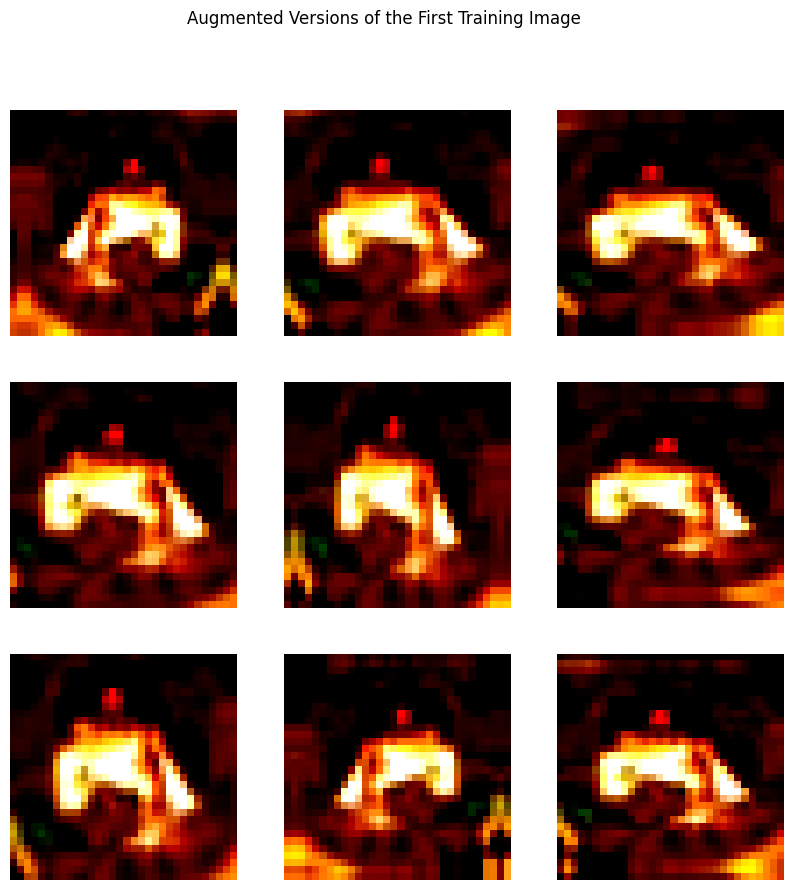

In [9]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

# Visualize Augmentation
# Let's show how a single image changes after augmentation
plt.figure(figsize=(10, 10))
for i in range(9):
    augmented_image = data_augmentation(tf.expand_dims(x_train[0], 0))
    plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[0])
    plt.axis("off")
plt.suptitle("Augmented Versions of the First Training Image")
plt.show()

In [10]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72
patch_size = 6
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]
transformer_layers = 8
mlp_head_units = [2048, 1024]

Patch Creation Layer

Image Size: 72x72
Patch Size: 6x6
Patches per Image: 144
Elements per Patch: 108


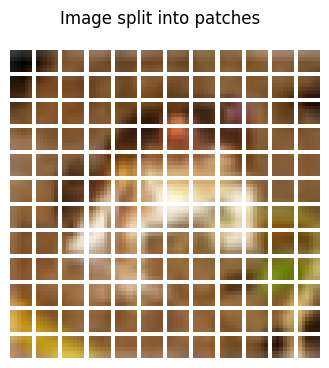

In [11]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Visualizing Patches
import cv2

sample_image = tf.image.resize(tf.convert_to_tensor([x_train[0]]), [image_size, image_size])
patches = Patches(patch_size)(sample_image)

print(f"Image Size: {image_size}x{image_size}")
print(f"Patch Size: {patch_size}x{patch_size}")
print(f"Patches per Image: {patches.shape[1]}")
print(f"Elements per Patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")
plt.show()

Patch Encoder Layer

In [12]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

Assemble the ViT Classifier

In [13]:
def mlp(x, hidden_units, dropout_rate):
    """Helper function to build a Multi-Layer Perceptron block."""
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def create_vit_classifier():
    inputs = layers.Input(shape=(32, 32, 3))

    # 1. Augment data
    augmented = data_augmentation(inputs)
    # 2. Create patches
    patches = Patches(patch_size)(augmented)

    # 3. Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # 4. Create multiple Transformer blocks
    for _ in range(transformer_layers):
        # Layer Normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Multi-Head Attention
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP Block
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        encoded_patches = layers.Add()([x3, x2])

    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # 6. MLP Head
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # 7. Classify outputs
    logits = layers.Dense(10)(features)
    
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

vit_classifier = create_vit_classifier()
vit_classifier.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 32, 32, 3) │          7 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_1 (Patches) │ (None, None, 108) │          0 │ data_augmentatio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder       │ (None, 144, 64)   │     16,192 │ patches_1[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 144, 64)   │        128 │ patch_encoder[0]… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 144, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 144, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 144, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 144, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 144, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 144, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 144, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 144, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 144, 128)  │          0 │ dense_3[0][0]   

 Total params: 21,666,769 (82.65 MB)

 Trainable params: 21,666,762 (82.65 MB)

 Non-trainable params: 7 (32.00 B)

Compile the Model

In [14]:
# Creating AdamW optimizer
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)
# Compiling the model
vit_classifier.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

Model compiled successfully.


Training the Model

Epoch 1/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 121s 122ms/step - accuracy: 0.2641 - loss: 2.4111 - top-5-accuracy: 0.7616 - val_accuracy: 0.4839 - val_loss: 1.4098 - val_top-5-accuracy: 0.9262
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 124ms/step - accuracy: 0.4355 - loss: 1.5773 - top-5-accuracy: 0.8979 - val_accuracy: 0.5393 - val_loss: 1.2871 - val_top-5-accuracy: 0.9412
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 124ms/step - accuracy: 0.4957 - loss: 1.4277 - top-5-accuracy: 0.9180 - val_accuracy: 0.5808 - val_loss: 1.1748 - val_top-5-accuracy: 0.9485
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 124ms/step - accuracy: 0.5336 - loss: 1.3208 - top-5-accuracy: 0.9327 - val_accuracy: 0.6185 - val_loss: 1.0866 - val_top-5-accuracy: 0.9584
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 124ms/step - accuracy: 0.5715 - loss: 1.2312 - top-5-accuracy: 0.9437 - val_accuracy: 0.6482 - val_loss: 1.0258 - val_top-5-accuracy: 0.9592
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 97s 124ms/step - accuracy: 0

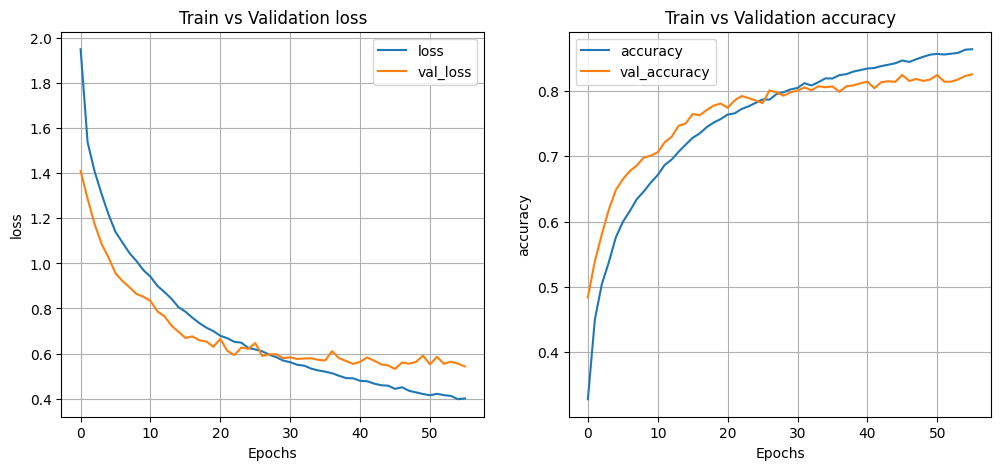

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
data_augmentation.layers[0].adapt(x_train)

vit_classifier = create_vit_classifier()
optimizer = keras.optimizers.AdamW(
    learning_rate=learning_rate, weight_decay=weight_decay
)
vit_classifier.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
        keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)
checkpoint_filepath = "/tmp/checkpoint.weights.h5"
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=True,
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=10,
    restore_best_weights=True
)
history = vit_classifier.fit(
    train_ds,
    validation_data=val_ds,
    epochs=num_epochs,
    callbacks=[checkpoint_callback, early_stopping],
)
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title(f"Train vs Validation {item}")
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plot_history("loss")
plt.subplot(1, 2, 2)
plot_history("accuracy")
plt.show()

Evaluation on Test Set

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.8239 - loss: 0.5497 - top-5-accuracy: 0.9909

Test Accuracy: 82.55%
Top-5 Test Accuracy: 99.03%
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step


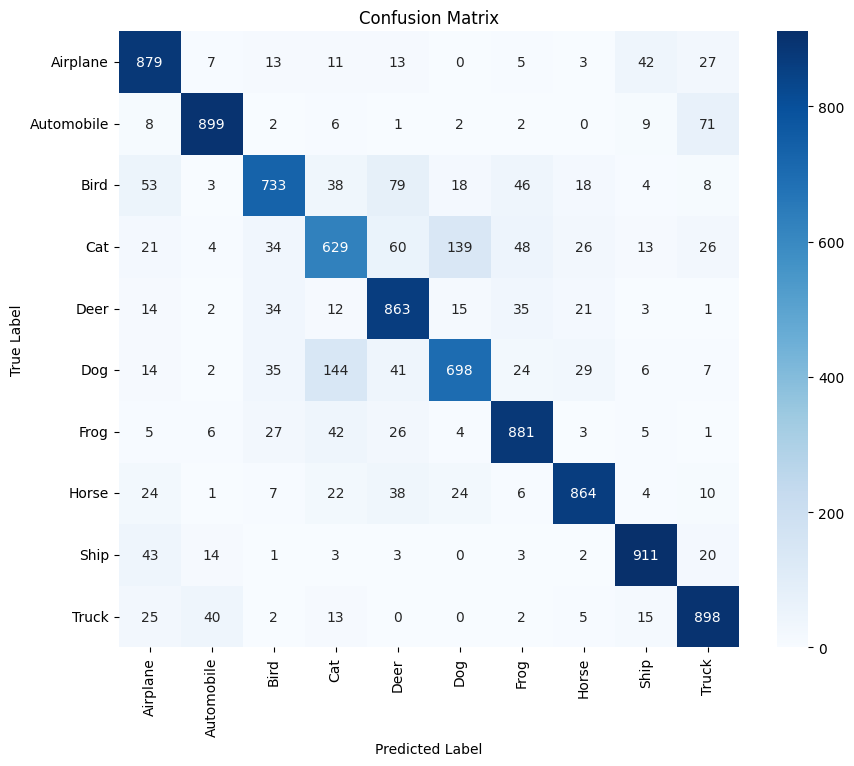

              precision    recall  f1-score   support

    Airplane       0.81      0.88      0.84      1000
  Automobile       0.92      0.90      0.91      1000
        Bird       0.83      0.73      0.78      1000
         Cat       0.68      0.63      0.66      1000
        Deer       0.77      0.86      0.81      1000
         Dog       0.78      0.70      0.73      1000
        Frog       0.84      0.88      0.86      1000
       Horse       0.89      0.86      0.88      1000
        Ship       0.90      0.91      0.91      1000
       Truck       0.84      0.90      0.87      1000

    accuracy                           0.83     10000
   macro avg       0.82      0.83      0.82     10000
weighted avg       0.82      0.83      0.82     10000



In [16]:
vit_classifier.load_weights(checkpoint_filepath)
_, accuracy, top_5_accuracy = vit_classifier.evaluate(x_test, y_test)

print(f"\nTest Accuracy: {round(accuracy * 100, 2)}%")
print(f"Top-5 Test Accuracy: {round(top_5_accuracy * 100, 2)}%")

# Generate Confusion Matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions
y_probs = vit_classifier.predict(x_test)
y_preds = np.argmax(y_probs, axis=1)

# Plot Matrix
conf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print Classification Report
print(classification_report(y_test, y_preds, target_names=class_names))